<a href="https://colab.research.google.com/github/xmpuspus/Energy-Peak-Demand-Forecast/blob/master/EnergyPeakDemandForecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Packages

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import pandas_profiling as pp
%matplotlib inline

# Load Data

In [0]:
data = pd.read_excel('Demand Forecast Dataset.xlsx')

In [0]:
data.head()

,Date,Year,Quarter,Day,Holiday,"Peak Demand, MW","Minimum Temp, degC","Maximum Temp, degC","GDP (Growth Rate, %)","GVA in Electricity (Growth Rate, %)"
0,2011-02-01,2011,1,3,0,5957.1,22.222222,28.888889,4.58422,2.0
1,2011-02-02,2011,1,4,0,5879.2,22.222222,28.888889,4.58422,2.0
2,2011-02-03,2011,1,5,0,5840.9,23.888889,28.888889,4.58422,2.0
3,2011-02-04,2011,1,6,0,6038.9,23.888889,28.888889,4.58422,2.0
4,2011-02-05,2011,1,7,0,5699.2,25.000000,28.888889,4.58422,2.0


In [0]:
data.columns

Index(['Date', 'Year', 'Quarter', 'Day', 'Holiday', 'Peak Demand, MW',
       'Minimum Temp, degC', 'Maximum Temp, degC', 'GDP  (Growth Rate, %)',
       'GVA in Electricity (Growth Rate, %)'],
      dtype='object')

In [0]:
data.dtypes

Date                                   datetime64[ns]
Year                                            int64
Quarter                                         int64
Day                                             int64
Holiday                                         int64
Peak Demand, MW                               float64
Minimum Temp, degC                            float64
Maximum Temp, degC                            float64
GDP  (Growth Rate, %)                         float64
GVA in Electricity (Growth Rate, %)           float64
dtype: object

In [0]:
data.Date.min(), data.Date.max()

(Timestamp('2011-02-01 00:00:00'), Timestamp('2019-06-30 00:00:00'))

We have hourly peak demand data from 2011 to 2019.

# Correlogram

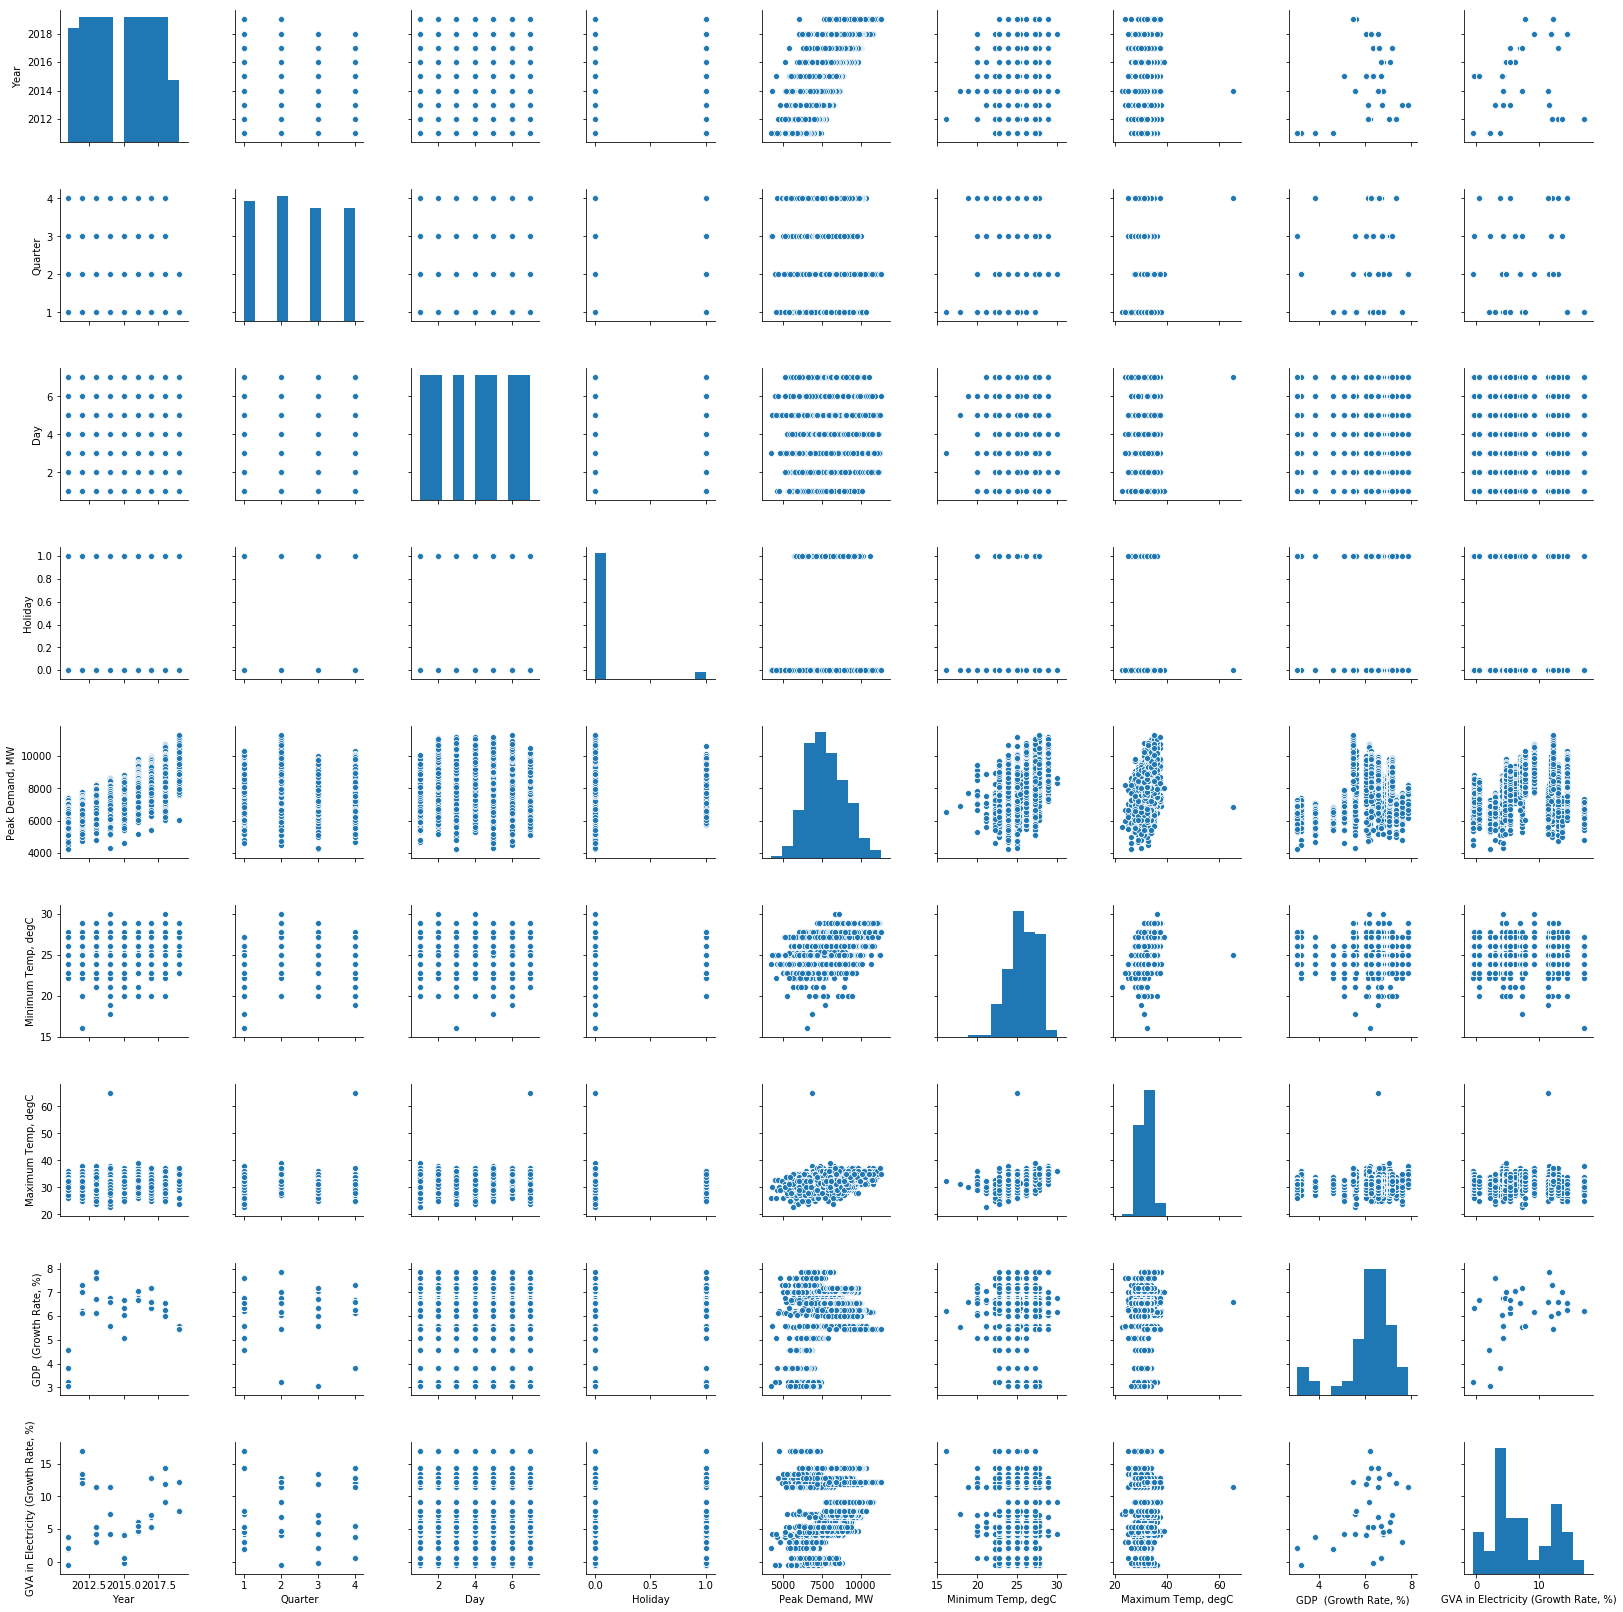

In [0]:
sns.pairplot(data)

# Correlation Strength

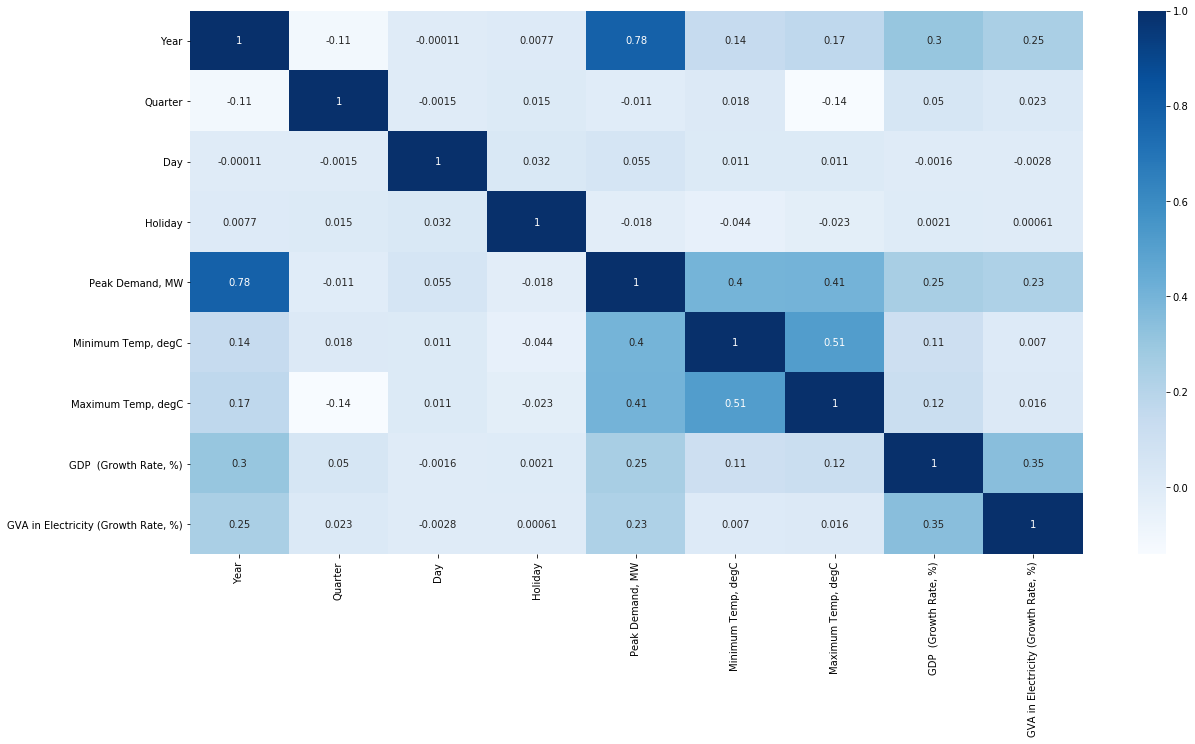

In [0]:
plt.subplots(figsize=(20, 10))
sns.heatmap(data.corr(), annot=True, cmap='Blues')

Looks like there is an apparent year-on-year increase in peak demand as shown by a high correlation strength of 78%. Temperature is also unsurprisingly correlated with peak demand.

# Hourly Temperature

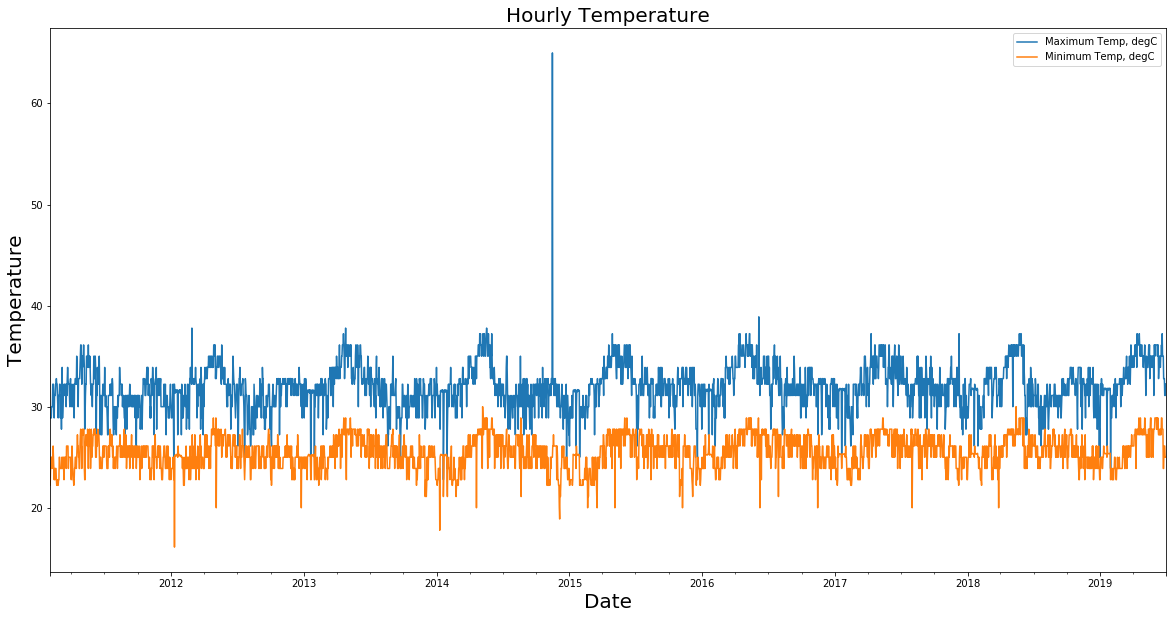

In [0]:
plt.subplots(figsize=(20, 10))
ax = data.set_index('Date')['Maximum Temp, degC'].plot()
data.set_index('Date')['Minimum Temp, degC'].plot(ax=ax)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Temperature', fontsize=20)
plt.title('Hourly Temperature', fontsize=20)
plt.legend()
plt.show()

Apparent seasonality in temperature but not as correlated with demand due to its biased increase through time.

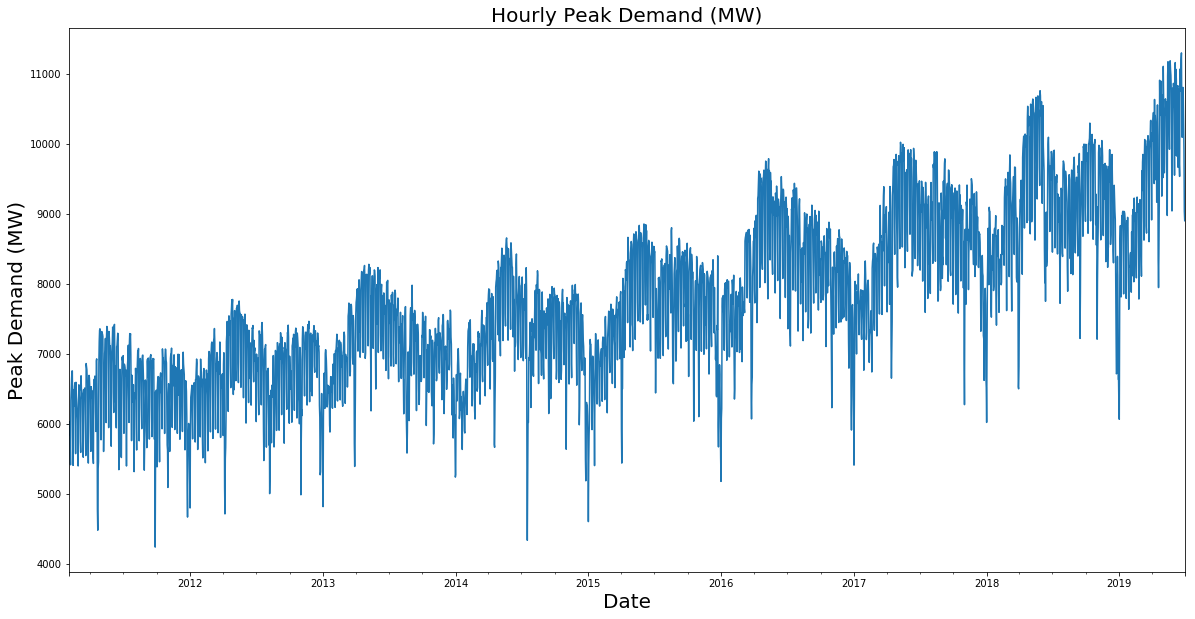

In [0]:
 plt.subplots(figsize=(20, 10))
data.set_index('Date')['Peak Demand, MW'].plot(label='Peak Demand')
plt.xlabel('Date', fontsize=20)
plt.ylabel('Peak Demand (MW)', fontsize=20)
plt.title('Hourly Peak Demand (MW)', fontsize=20)
plt.show()


# Modelling

Forecast the future.

In [0]:
data.head()

,Date,Year,Quarter,Day,Holiday,"Peak Demand, MW","Minimum Temp, degC","Maximum Temp, degC","GDP (Growth Rate, %)","GVA in Electricity (Growth Rate, %)"
0,2011-02-01,2011,1,3,0,5957.1,22.222222,28.888889,4.58422,2.0
1,2011-02-02,2011,1,4,0,5879.2,22.222222,28.888889,4.58422,2.0
2,2011-02-03,2011,1,5,0,5840.9,23.888889,28.888889,4.58422,2.0
3,2011-02-04,2011,1,6,0,6038.9,23.888889,28.888889,4.58422,2.0
4,2011-02-05,2011,1,7,0,5699.2,25.000000,28.888889,4.58422,2.0


In [0]:
indexed_data = data.set_index("Date").copy()

In [0]:
y_orig = indexed_data['Peak Demand, MW']
yn = indexed_data['Peak Demand, MW'].resample('D').max()

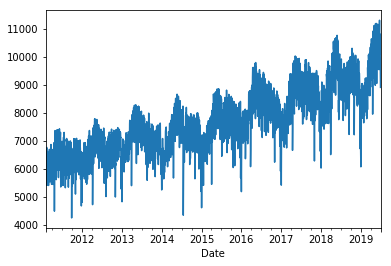

In [0]:
yn.plot()

In [0]:
# Check if there are empty/null days. Outputs zero if none
yn.isna().sum()

0

Data is clean.

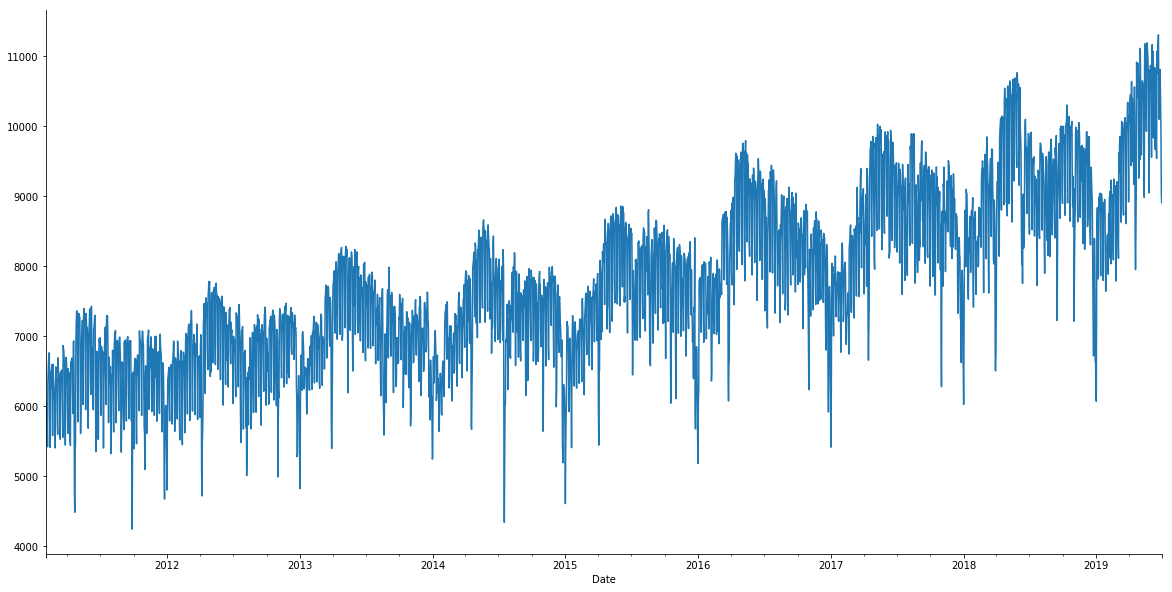

In [0]:
ax = plt.subplot()
ax = yn.plot(label='Peak Energy Demand (MW)', figsize=(20, 10))


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Forcast using Prophet

Prophet is an open source library published by Facebook that is based on decomposable (trend+seasonality+holidays) models. It provides us with the ability to make time series predictions with good accuracy using simple intuitive parameters and has support for including impact of custom seasonality and holidays!

Here's the resource for more information on [Prophet](https://www.analyticsvidhya.com/blog/2018/05/generate-accurate-forecasts-facebook-prophet-python-r/).

In [0]:
!pip install fbprophet

In [0]:
# Load Prophet
from fbprophet import Prophet
pd.options.display.max_columns = 999

In [0]:
# Reassign columns as input to Prophet
yn_df = pd.DataFrame(yn)
yn_df['y'] = yn_df['Peak Demand, MW']
yn_df['ds'] = yn_df.index
yn_df['holiday'] = np.where(data['Holiday'] == 1, 'Y', 'N')

In [0]:
yn_df.head()

,"Peak Demand, MW",y,ds,holiday
Date,,,,
2011-02-01,5957.1,5957.1,2011-02-01,N
2011-02-02,5879.2,5879.2,2011-02-02,N
2011-02-03,5840.9,5840.9,2011-02-03,N
2011-02-04,6038.9,6038.9,2011-02-04,N
2011-02-05,5699.2,5699.2,2011-02-05,N


In [0]:
# Let's treat data before 2018 as train data and forecast for beyond 2018 as test data
date_split = '2018-01-01'
train, test = yn_df[:date_split], yn_df[date_split:]

In [0]:
train.shape, test.shape

((2527, 4), (546, 4))

Around an 80-20 split looks reasonable.

In [0]:
# Forecast for how many days?

days = 365
m = Prophet(yearly_seasonality = True, weekly_seasonality=True, seasonality_prior_scale=0.1, holidays=yn_df[['ds', 'holiday']], )

# Let's train the model
m.fit(train)
future = m.make_future_dataframe(periods=(test.shape[0]+(days)))
forecast = m.predict(future)

/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:159: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [0]:
train.head()

,"Peak Demand, MW",y,ds,holiday
Date,,,,
2011-02-01,5957.1,5957.1,2011-02-01,N
2011-02-02,5879.2,5879.2,2011-02-02,N
2011-02-03,5840.9,5840.9,2011-02-03,N
2011-02-04,6038.9,6038.9,2011-02-04,N
2011-02-05,5699.2,5699.2,2011-02-05,N


In [0]:
train.dtypes

Peak Demand, MW           float64
y                         float64
ds                 datetime64[ns]
holiday                    object
dtype: object

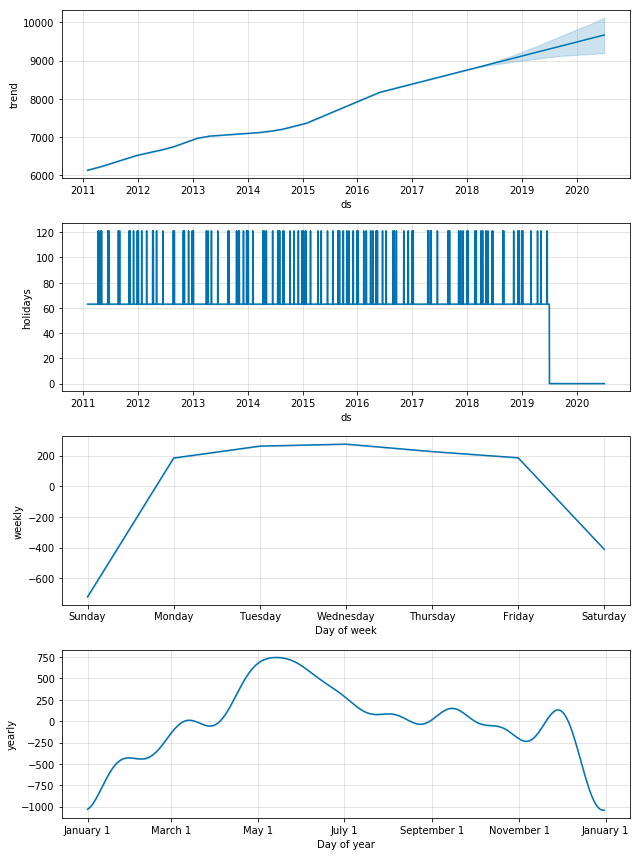

In [0]:
m.plot_components(forecast)
plt.show()

- We can see that the months with low demands are months ranging from January to December (as expected) since its colder.
- Looking at weekly trends, weekends always have lower demand.

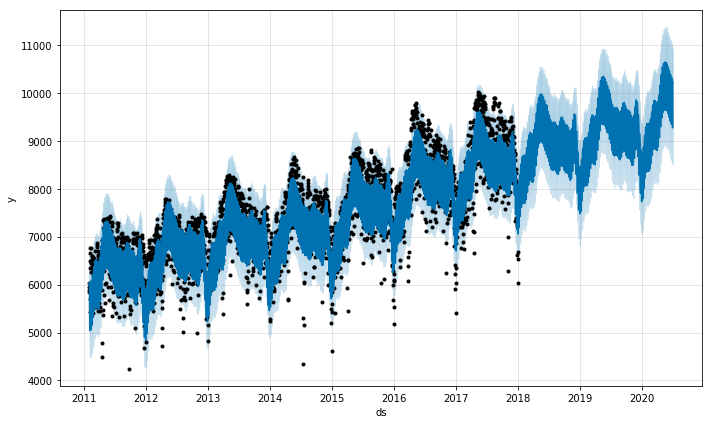

In [0]:
m.plot(forecast)
plt.show()

In [0]:
test_df = pd.merge(forecast.set_index('ds')['2018':].reset_index(), test, on='ds', how='left')
test_df.index = test_df['ds']

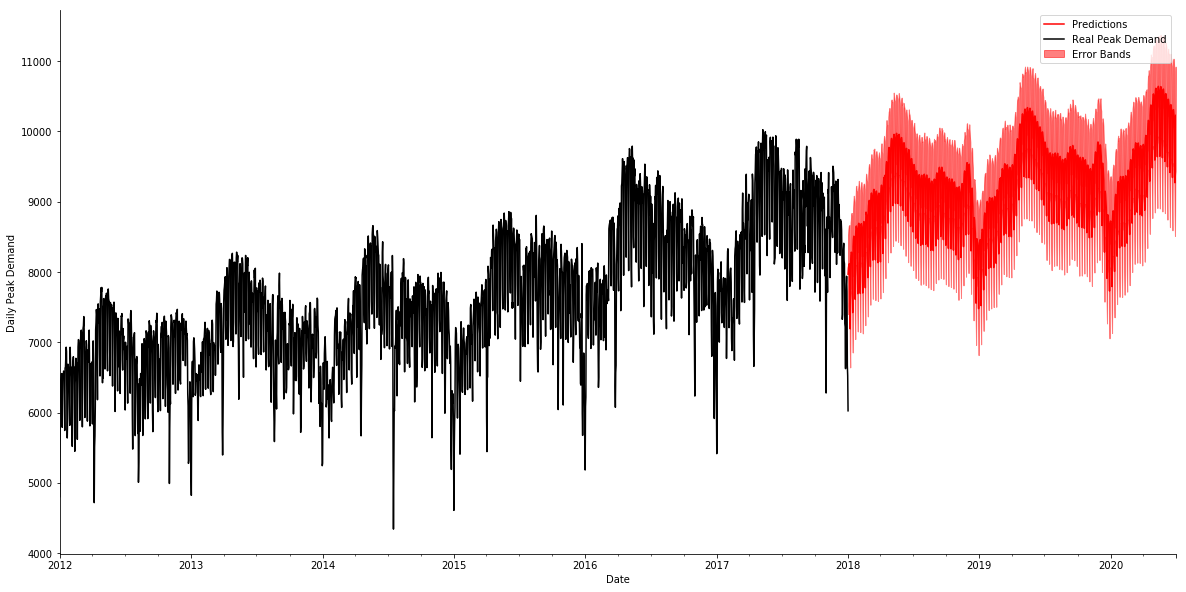

In [0]:
pd.plotting.register_matplotlib_converters()

ax = test_df.yhat.plot(figsize=(20, 10), color='r')

yn_df['2012-01-01':date_split].y.plot(ax=ax, color='k')
# test_df.yhat.plot(ax=ax, style='--', color='r')

ax.fill_between(test_df.index,
                test_df.yhat_lower,
                test_df.yhat_upper, color='r', alpha=.5)
ax.set_xlabel('Date')
ax.set_ylabel('Daily Peak Demand')

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(['Test', 'Training'])

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


plt.legend(['Predictions', 'Real Peak Demand', 'Error Bands'])
plt.show()


# Performance Metrics

In [0]:
# Cross Validation
from fbprophet.diagnostics import cross_validation
df_cv = cross_validation(m, initial='365 days', period='30 days', horizon = '30 days')
df_cv.head()

INFO:fbprophet:Making 72 forecasts with cutoffs between 2012-02-02 00:00:00 and 2017-12-02 00:00:00
/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:159: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:159: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/fbprophet/forecaster.py:159: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-02-03,6825.986290,6387.116109,7252.408692,6509.1,2012-02-02
1,2012-02-04,6254.163854,5768.903979,6689.435096,5793.8,2012-02-02
2,2012-02-05,5884.513603,5441.207569,6277.066206,5519.4,2012-02-02
3,2012-02-06,6880.417579,6442.632501,7319.938209,6608.7,2012-02-02
4,2012-02-07,6964.335426,6521.095159,7408.297005,6733.9,2012-02-02


In [0]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2012-02-03,6825.986290,6387.116109,7252.408692,6509.1,2012-02-02
1,2012-02-04,6254.163854,5768.903979,6689.435096,5793.8,2012-02-02
2,2012-02-05,5884.513603,5441.207569,6277.066206,5519.4,2012-02-02
3,2012-02-06,6880.417579,6442.632501,7319.938209,6608.7,2012-02-02
4,2012-02-07,6964.335426,6521.095159,7408.297005,6733.9,2012-02-02


In [0]:
from fbprophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv, ['mape'])
df_p.head()

,horizon,mape
0,3 days,0.044760
1,4 days,0.049228
2,5 days,0.049605
3,6 days,0.047450
4,7 days,0.047056


# Visualize Metrics

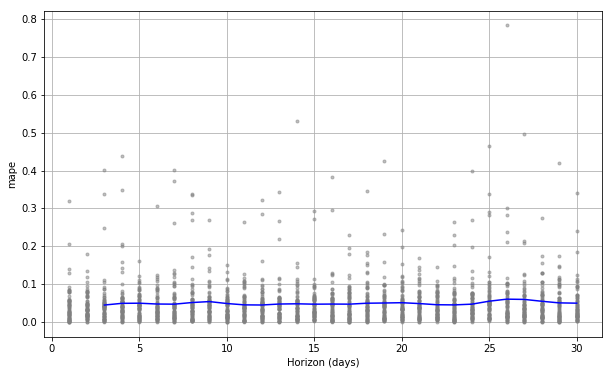

In [0]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')